In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

In [2]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = GradientBoostingClassifier(n_estimators=200,max_features='sqrt',random_state=2021).fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "gbdt_nooverlap_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.6199     ,    0.7778     ,    0.6278     ,    0.0972     ,    0.1728     
  0  ,    0.9591     ,    0.2222     ,    0.9222     ,    0.2222     ,    0.2222     
  1  ,    0.4795     ,    0.5000     ,    0.4804     ,    0.0430     ,    0.0792     
  1  ,    0.9532     ,    0.1250     ,    0.9162     ,    0.1111     ,    0.1176     
  2  ,    0.6842     ,    0.5000     ,    0.6760     ,    0.0690     ,    0.1212     
  2  ,    0.9708     ,    0.1250     ,    0.9330     ,    0.1667     ,    0.1429     
  3  ,    0.4386     ,    1.0000     ,    0.4637     ,    0.0769     ,    0.1429     
  3  ,    0.9532     ,    0.0000     ,    0.9106     ,    0.0000     ,      nan      


<ipython-input-2-f3d442748934>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  4  ,    0.8294     ,    0.3333     ,    0.8045     ,    0.0938     ,    0.1463     
  4  ,    0.9647     ,    0.0000     ,    0.9162     ,    0.0000     ,      nan      
              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75       854
         1.0       0.07      0.62      0.13        42

    accuracy                           0.61       896
   macro avg       0.52      0.61      0.44       896
weighted avg       0.93      0.61      0.72       896



<ipython-input-2-f3d442748934>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


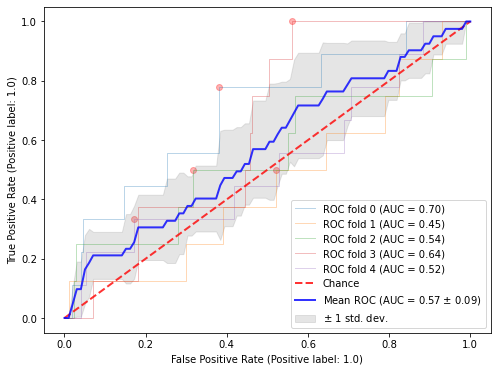

[0.695906432748538, 0.44883040935672514, 0.5423976608187134, 0.6425438596491229, 0.5209150326797386]
0.5701186790505676
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8427     ,    0.7333     ,    0.8342     ,    0.2821     ,    0.4074     
  0  ,    0.9438     ,    0.5333     ,    0.9119     ,    0.4444     ,    0.4848     
  1  ,    0.7472     ,    1.0000     ,    0.7668     ,    0.2500     ,    0.4000     
  1  ,    0.9494     ,    0.6000     ,    0.9223     ,    0.5000     ,    0.5455     
  2  ,    0.7416     ,    0.9333     ,    0.7565     ,    0.2333     ,    0.3733     
  2  ,    0.9494     ,    0.6667     ,    0.9275     ,    0.5263     ,    0.5882     
  3  ,    0.7416     ,    0.8667     ,    0.7513     ,    0.2203     ,    0.3514     
  3  ,    0.9382     ,    0.4667     ,    0.9016     ,    0.3889     ,    0.4242     
  4  ,    0.7119     ,    1.0000     ,    0.7344     ,    0.2273     ,

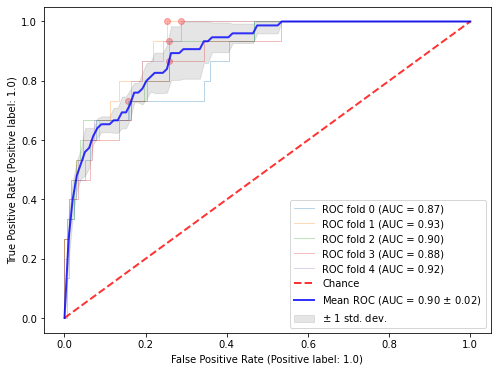

[0.8655430711610488, 0.9258426966292135, 0.899625468164794, 0.8786516853932584, 0.9175141242937853]
0.8974354091284201
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9180     ,    0.9231     ,    0.9182     ,    0.3636     ,    0.5217     
  0  ,    0.9883     ,    0.5769     ,    0.9684     ,    0.7143     ,    0.6383     
  1  ,    0.9746     ,    0.7692     ,    0.9647     ,    0.6061     ,    0.6780     
  1  ,    0.9863     ,    0.5769     ,    0.9665     ,    0.6818     ,    0.6250     
  2  ,    0.9609     ,    0.8462     ,    0.9554     ,    0.5238     ,    0.6471     
  2  ,    0.9922     ,    0.6923     ,    0.9777     ,    0.8182     ,    0.7500     
  3  ,    0.7598     ,    1.0000     ,    0.7709     ,    0.1689     ,    0.2890     
  3  ,    0.9883     ,    0.6800     ,    0.9739     ,    0.7391     ,    0.7083     
  4  ,    0.9688     ,    0.9200     ,    0.9665     ,    0.5897     , 

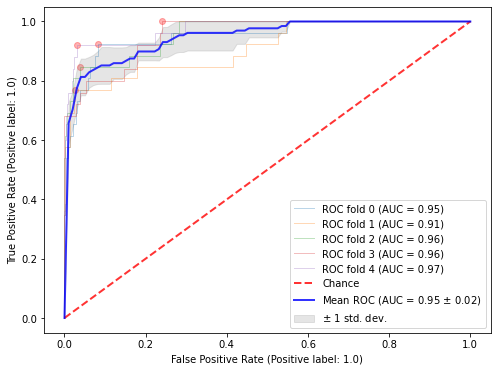

[0.9519981971153846, 0.9102313701923077, 0.9595853365384616, 0.95609375, 0.9740625]
0.9503942307692308
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.6818     ,    0.8000     ,    0.6947     ,    0.2353     ,    0.3636     
  0  ,    0.9056     ,    0.4857     ,    0.8598     ,    0.3864     ,    0.4304     
  1  ,    0.7867     ,    0.8571     ,    0.7944     ,    0.3297     ,    0.4762     
  1  ,    0.8986     ,    0.6286     ,    0.8692     ,    0.4314     ,    0.5116     
  2  ,    0.8252     ,    0.8571     ,    0.8287     ,    0.3750     ,    0.5217     
  2  ,    0.8741     ,    0.6286     ,    0.8474     ,    0.3793     ,    0.4731     
  3  ,    0.8531     ,    0.6765     ,    0.8344     ,    0.3538     ,    0.4646     
  3  ,    0.8846     ,    0.6176     ,    0.8562     ,    0.3889     ,    0.4773     
  4  ,    0.7692     ,    0.7353     ,    0.7656     ,    0.2747     ,    0.4000     
 

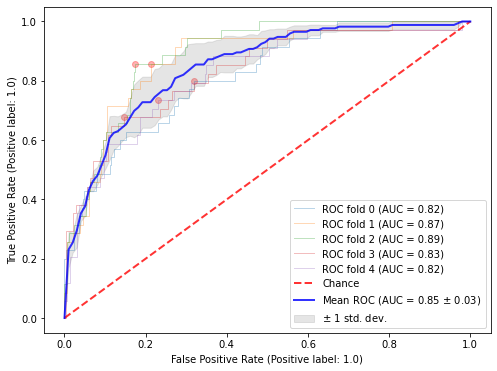

[0.8161838161838162, 0.8742257742257743, 0.88991008991009, 0.8317564788153023, 0.820855614973262]
0.846586354821649
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8688     ,    1.0000     ,    0.8772     ,    0.3438     ,    0.5116     
  0  ,    0.9875     ,    0.6364     ,    0.9649     ,    0.7778     ,    0.7000     
  1  ,    0.9437     ,    1.0000     ,    0.9474     ,    0.5500     ,    0.7097     
  1  ,    0.9750     ,    0.8182     ,    0.9649     ,    0.6923     ,    0.7500     
  2  ,    0.9812     ,    1.0000     ,    0.9825     ,    0.7857     ,    0.8800     
  2  ,    0.9875     ,    0.7273     ,    0.9708     ,    0.8000     ,    0.7619     
  3  ,    0.9437     ,    0.9091     ,    0.9415     ,    0.5263     ,    0.6667     
  3  ,    0.9812     ,    0.6364     ,    0.9591     ,    0.7000     ,    0.6667     
  4  ,    0.9062     ,    1.0000     ,    0.9118     ,    0.4000     ,    

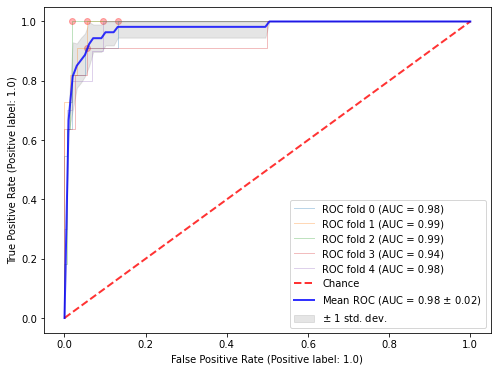

[0.9795454545454546, 0.9909090909090909, 0.9909090909090909, 0.9448863636363636, 0.979375]
0.977125
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9474     ,    1.0000     ,    0.9600     ,    0.8571     ,    0.9231     
  0  ,    1.0000     ,    0.8333     ,    0.9600     ,    1.0000     ,    0.9091     
  1  ,    1.0000     ,    0.6667     ,    0.9200     ,    1.0000     ,    0.8000     
  1  ,    1.0000     ,    0.6667     ,    0.9200     ,    1.0000     ,    0.8000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     


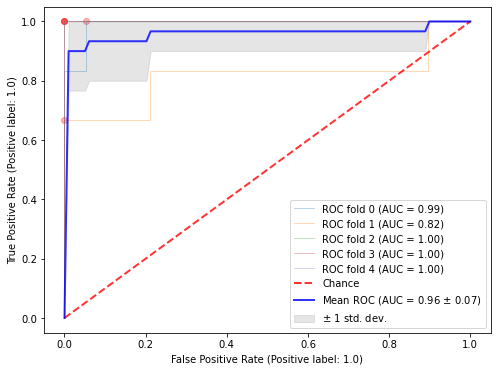

[0.9912280701754387, 0.8157894736842105, 1.0, 1.0, 1.0]
0.9614035087719298
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8750     ,    1.0000     ,    0.9091     ,    0.7500     ,    0.8571     
  0  ,    0.9375     ,    0.8333     ,    0.9091     ,    0.8333     ,    0.8333     
  1  ,    0.8125     ,    1.0000     ,    0.8636     ,    0.6667     ,    0.8000     
  1  ,    0.8750     ,    0.6667     ,    0.8182     ,    0.6667     ,    0.6667     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.7143     ,    0.9091     ,    1.0000     ,    0.8333     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.8571     ,    0.9545     ,    1.0000     ,    0.9231     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,   

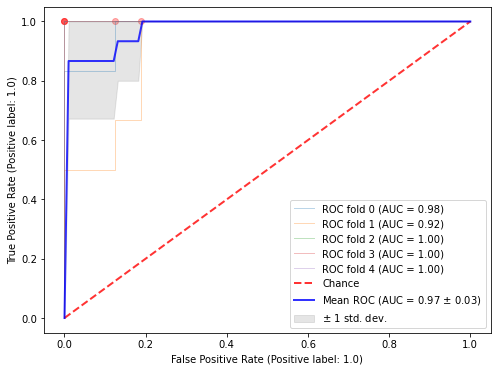

[0.9791666666666666, 0.9166666666666666, 1.0, 1.0, 1.0]
0.9791666666666666


In [4]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"][::3].to_numpy()
    data_x = data.loc[::3, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))